In [1]:
#maybe not all imports are necessary

import sys
print(sys.version)
import time
import datetime
import math
import scipy.ndimage
import scipy as sp
import numpy as np
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.image as mpimg
from matplotlib.patches import ConnectionPatch
from matplotlib.colors import LinearSegmentedColormap
import MDAnalysis
from MDAnalysis.analysis import align
import MDAnalysis.lib.qcprot as qcp
from IPython.display import clear_output
import builtins
import io as IO
import pickle

# define a function to convert all zeros in an array to nan ("non a number")
def zero_to_nan(values):
    return [float('nan') if x==0 else x for x in values]

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
### This is the main analysis box ###
### All parts you need to change  ###
### according to your system are  ###
### marked with "###"             ###
### You can of cause later change ###
### internal variables as you wish###
### Happy analysing!              ###
 

### Path to your trajectory files folder
Path="/media/user1/3f01b061-6b30-485c-8565-c41ef5a79485/8tb/trek2/trek2brohawn-alignment/new-trek2brohawn-mutatetrek1/trek2up/compel/prod/hlrndone/2e/1/"

### analyse only every 5th frame to be faster (choose a number that fits to your data size and time)
skip=5

### open the trajectory. If it is in xtc format you need a corresponding pdb file
traj=MDAnalysis.core.universe.Universe(Path+"/v+centerilk.pdb",Path+"/v+center.xtc") ## ( note for myself: traj__comp_100_150ns_skip10.xtc from the paper K+ movie 1)
# for the timescale in later analysis we need:
### integration timestep
dt=0.004 # ps
### gmx xtc (or trr or pdb) output every ... frames
outputstep=10000
# so the time inbetween the analysis output steps is
mystep=dt/1000*outputstep*skip

# get the number of frames
nframes = len(traj.trajectory)

### define a cylinder space around the center of mass (COM) of your channel. Within this cylinder the ions will be tracked
height=60 # from 50 Å above
depth=-60 # till 30 Å below the COM
radius=40 # with a radius of 15 Å

### get the number of iomns oin the system (Normally it is "K" or "POT" for potassium of "NA" or "SOD" for sodium ("CL" or "CLA" for Cl-))
ions  = traj.select_atoms('name K', updating=True)
nIons = ions.n_atoms

# the ion z-axis position will be summed up into an ion occupancy with the bin width of 0.1 Å (10 bins per Å)
binsPerA=10
binsZ=(height-depth)*binsPerA # total number of bins in z-direction (cylinder hight * "bins ber Å")
binsXY=radius*binsPerA # radial number of bins for two-dimensional ion occupancy

# all results are saved for: upper and lower channel

# save ion z-axis positions i.e. Ion Track. for upper/lower channel, per analysed frame and per analysed ion
ionTrack=np.zeros((2,int(nframes/skip)+1,nIons))

# ion occupancy 1D
io=np.zeros((2,binsZ))

# ion occupancy 2D
io2D=np.zeros((2,binsZ,binsXY))

# hint: you can repeat or duplicate the ion occupancy and ion track analysis for anions and water if you like

### define a reference structure to align the channel to each frame
ref=MDAnalysis.core.universe.Universe(Path+"/v+centerilk.pdb")

### from the reference structure defint the subset of atoms you want your channel to be aligned to
ref_atoms  =  ref.select_atoms('(index 1652:1741 or index 3589:3674 or index 6519:6608 or index 8456:8541) and (name CA or name C)') # it take the backbone carbons from the lower selectivity filter residues
# more information about MDAnalysis selection commands: https://docs.mdanalysis.org/2.0.0-dev0/documentation_pages/selections.html
# "prop z < 110" ensures, that we define the lower channel only. But it is not necessary.
# MDAnalysis gives new residue numbers to the upper channel (the upper channel is written after the lower channel in the pdb). 
# MDAnalysis gives the upper (last read) channel its residue numbers+20000 (sometimes MDAnalysis adds also 30000) (see in the next atom selection)

# center of mass of the reference
ref_com = ref_atoms.center_of_mass()

### define groups in the trajectory for the same selection for the upper and lower channel.
traj_atoms_u = traj.select_atoms('(index 1652:1741 or index 3589:3674 or index 6519:6608 or index 8456:8541) and (name CA or name C)')

### get a list of ions that are within the defined cylinder around the COM of the upper/lower channel. This selection is updated every frame.
ions_u   = traj.select_atoms('name K and cyzone %f %f %f ((index 1652:1741 or index 3589:3674 or index 6519:6608 or index 8456:8541) and (name CA or name C))' %(radius, height,depth), updating=True)

# stop the clock to get later an estimate of the remaining time for analysis
start_time = time.time()

# loop through the trajectory
for k, ts in enumerate(traj.trajectory):
    # frequently (every 100 stepts) give information about the current step and expected residual runtime)
    if(k%100==0 and k!=0):
        clear_output() # clear all previous output (to get not a very long list of time outputs)
        s=(time.time() - start_time)/k*(traj.trajectory.n_frames-k)
        print("analyse frame", k, "of", nframes)
        print("%.2f" %(k/(traj.trajectory.n_frames)*100), "%: ", int(s//(60*60)), "h,", int((s%(60*60))//60), "m,", int(s%60), "s to go")
    # skip a defined amount of frames and than analyse one
    if(k%skip==0):

        # get the center of mass for the upper and lower channel
        x_com_u  = traj_atoms_u.center_of_mass()

        # loop through the analysis for the upper and the lower channel 0=lower channel 1=upper channel
        for u in [0]:

            # for the upper/lower channel subtract the current center of mass, and add the center of mass from the reference (lower channel) for every atom
            if u==0:
                # Transform each atom in the trajectory (use inplace ops to avoid copying arrays)
                ts._pos -= x_com_u
                ts._pos += ref_com
            else:
                # Transform each atom in the trajectory (use inplace ops to avoid copying arrays)
                ts._pos += x_com_u
                ts._pos -= x_com_l

            # copy the current position of ion within the defined cylindirc space around the channels COM
            ion      = np.array([ions_u.positions.copy()])

            # go through all cations (near the respective upper/lower channel)         
            for i in np.arange(ion[u].shape[0]): 
                # the position of this ion in pore axis / z-axis ("normalized")
                z=ion[u][i][2]-ref_com[2]-depth # position within the cylinder
                # ceck further if this ion is really within the analysis borders
                if (z>0 and z<(height-depth)): 
                    # very complicated: we have to get the "index" of the ion
                    # for that we get the MDAnalysis internal atom ID of the ion which is the atom number from the pdb-1
                    if u==0: 
                        # get the number of the ion from the pdb-id
                        # subtrackt one because pdb starts with atom id 1 and MDAnalysis starts with atom id 0
                        ni=ions_u[i].ix
                    else:
                        ni=ions_l[i].ix   
                    # depending on the order of your atoms in the pdb you might need to subtrackt just one number (if you ions are subsequently written in the pdb) or you need to distinguish between the ions you inserted in the two comparments (so they are separate in the pdb and have very different numbers. thats here the case)
                    if(ni>=(ions[int(nIons/2)].ix)): # if the ion is from the compartment that is written second in the pdb file, subtract the number of the the first ion occuring and add half of the total number of ions
                        ni=int((ni-ions[int(nIons/2)].ix))+int(nIons/2)
                    else: # if the ion is from the compartment that is written first in the pdb file, just subtract the number of the the first ion occuring in this compartment
                        ni=int((ni-ions[0].ix)) 
                    # -> "ni" is now a subsequent numbering from 0 to nions. each ion has its unique, subsequent ID
                    
                    # save the current ion position 
                    # save ionTrack for 1) upper or lower channel 2) the right analysed frame 3) the right ion ID
                    ionTrack[u][int(k/skip)][ni]=z # save the track of the ion
                    
                    # bin-position within the cylinder
                    z=int((ion[u][i][2]-ref_com[2]-depth)*binsPerA) 
                    
                    # one dimensional ion occupancy -> add a count for the respective bin (z)
                    io[u][z]+=1    
                    
                    # radial distance of the ion
                    rad=int(np.sqrt((ion[u][i][1]*binsPerA-ref_com[1]*binsPerA)**2+(ion[u][i][0]*binsPerA-ref_com[0]*binsPerA)**2)) 
                    # if the radius is within analysis borders
                    if(rad<radius*binsPerA):
                        # save 2D ion occupancy
                        io2D[u][z][rad]+=1  
                        

s = time.time()-start_time
print("took ", int(s//(60*60)), "h,", int((s%(60*60))//60), "m,", int(s%60))
print("the end")

analyse frame 12500 of 12501
99.99 %:  0 h, 0 m, 0 s to go
took  0 h, 3 m, 41
the end


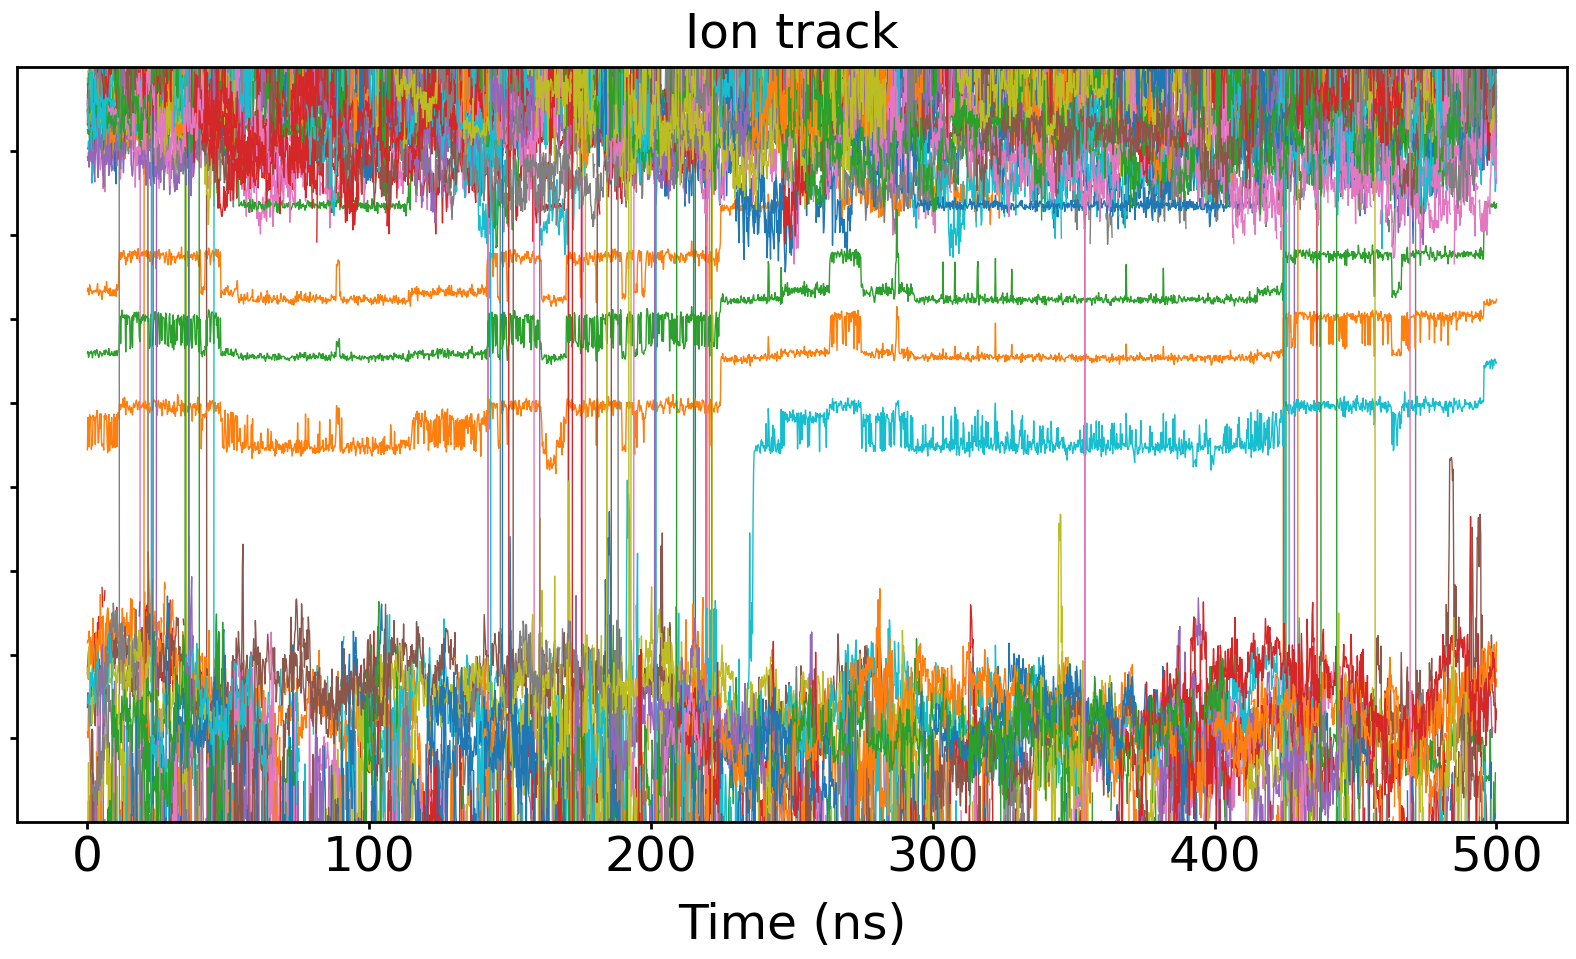

In [8]:
# plotting the results
# plot the ion track

# define plotting parameters
# the fontsize for text in the plot
myFontsize=35
# the distance between plot and labels
myPad=15

# since we pot a high resolution figure we want every drawn line to have at least two pixel width
plt.rcParams["axes.linewidth"]  = 2


# define the size of the figure (25x10) inch (i guess inch is the unit here) and how many dpi (dots/pixel per inch)
fig = plt.figure(figsize=(20, 10), dpi=100)

# define for the whole plot, that the axis labels are in the previously defined size
matplotlib.rc('xtick', labelsize=myFontsize) 
matplotlib.rc('ytick', labelsize=myFontsize) 

ax = fig.gca()
# tick size
ax.tick_params('both', length=5, width=2, which='major')
matplotlib.pyplot.yticks([0,5,10,15,20,25,30,35])
plt.ylim(40, -5)

# disable the y-axis numbers since we use the same scale as in the plot before
plt.tick_params(axis='y', which='both', labelleft=False, labelright=False)

# plot the ion track for all ions
for i in np.arange(nIons):
    # first array is a list of times for each analysed step, plotted against the ion z-axis track for every ion.
    plt.plot(np.arange(int(nframes/skip)+1)*mystep,np.array(zero_to_nan(ionTrack[0,:,i]))+depth+10, lw=1, label=i)

plt.xlabel('Time (ns)', fontsize=myFontsize,labelpad=myPad)
#plt.ylabel('Pore axis (Å)', fontsize=myFontsize,labelpad=myPad)
plt.title("Ion track", fontsize=myFontsize,pad=myPad)

plt.savefig(Path+'/IonTrack+v'+'.pdf')

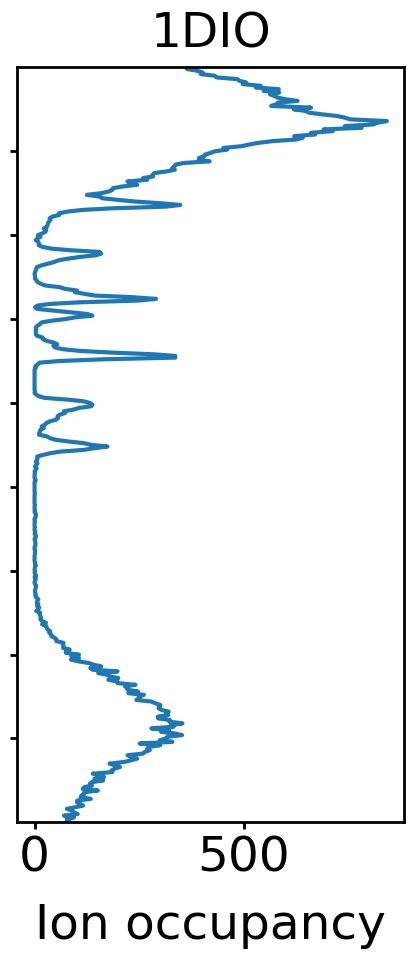

In [5]:
#plot ion occupancy 1D

# define plotting parameters
# the fontsize for text in the plot
myFontsize=35
# the distance between plot and labels
myPad=15

# since we pot a high resolution figure we want every drawn line to have at least two pixel width
plt.rcParams["axes.linewidth"]  = 2


# define the size of the figure (25x10) inch (i guess inch is the unit here) and how many dpi (dots/pixel per inch)
fig = plt.figure(figsize=(5, 10), dpi=100)

# define for the whole plot, that the axis labels are in the previously defined size
matplotlib.rc('xtick', labelsize=myFontsize) 
matplotlib.rc('ytick', labelsize=myFontsize) 

for u in [0]:
    # plot the second plot: ion occupancy in one dimension (along pore axis)
    ax = fig.gca()
    # set again the tick size
    ax.tick_params('both', length=5, width=2, which='major')
    
# disable the y-axis numbers since we use the same scale as in the plot before
    plt.tick_params(axis='y', which='both', labelleft=False, labelright=False)
    
    # set the y axis limits (min max) to the same as in the first plot, so that we can use the same axis
    plt.ylim(40, -5)
    # ensure, that the ticks are drawn in the same values as in the plot before
    matplotlib.pyplot.yticks([0,5,10,15,20,25,30,35])
    # plot the one dimensional ion occupancy
    ax.plot(io[u],np.arange(binsZ)/binsPerA+depth+10,lw=3) # I arbitrarily move the y-axis to begin 10 Å below the COM
    
    plt.xlabel('Ion occupancy', fontsize=myFontsize,labelpad=myPad)
    plt.title("1DIO", fontsize=myFontsize,pad=myPad)
    
plt.savefig(Path+'/1DIO+v'+'.pdf')

In [6]:
# we have to "normalize" the two dimensional ion occupancy since the outer bins cover more space than the inner bins
# the bins represent rings around the pore axis. and as the rings grow bigger they cover more space. we have to compensate according to that growth
# calculate a compensation factor for each bin within the radius
nor=np.zeros(binsXY)
for i in np.arange(np.size(nor)):
    # ring area hight*(outer circle area - inner circle area)
    # pi*height*(r1^2-r2^2)
    nor[i] = np.pi * 1/binsPerA * ( ((i+1)/binsPerA)**2 - ((i)/binsPerA)**2 )
# create new "normalized" 2DIO array 
io2Dnor=np.zeros((2,binsZ,binsXY))
for u in [0]:
    for j in np.arange(np.shape(io2D[u])[0]):
        # "normalize" according to their size
        io2Dnor[u][j]=io2D[u][j]/nor

# the normalized 2DIO contains now ions per Å^3 (summed up during the entire simulation)

/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: Log scale: values of z <= 0 have been masked
/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: Log scale: values of z <= 0 have been masked


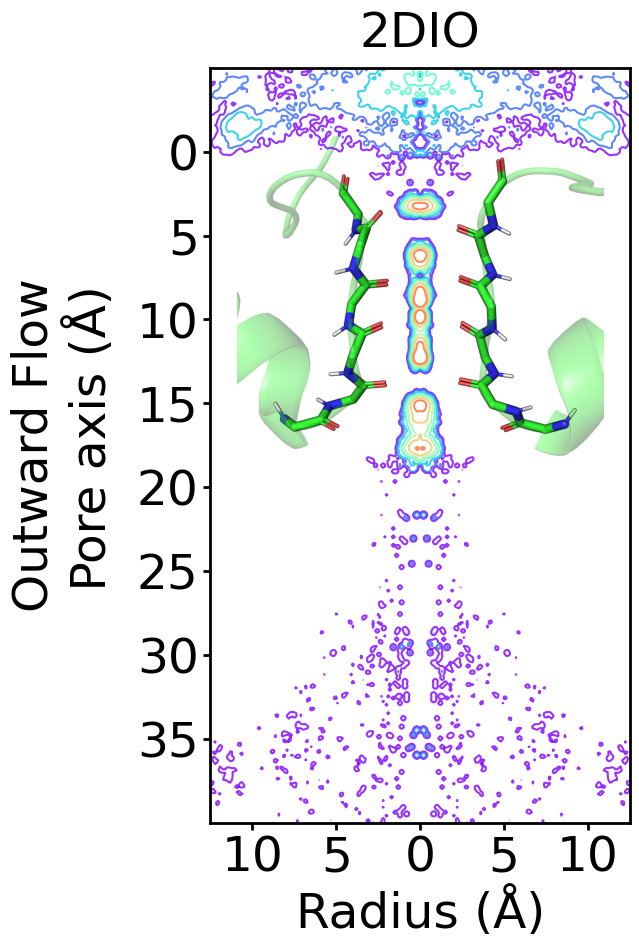

In [9]:
### you have to know how many pixel are plottet per pixel in your snapshot
pixPerA=110
### hshift and rshift (the horizontal and vertical shift) are the number of pixels from the respective side to the channels center of mass in the picture
rshift=1200
hshift=1200-10*pixPerA # I arbitrarily move the y-axis to begin 10 Å below the COM
### two functions to convert a position in the contour plot to a position in the snapshot-pixelmap
### the values of pixPerA (pixel per Å) and the horizontal and vertical shift (hshift, rshift) have to be adapted to your snapshot picture
def y_to_scale(values):
    return 2400-(np.array(values)*pixPerA+hshift)
def x_to_scale(values):
    return (np.array(values)*pixPerA+rshift)

# the used color map for plotting the 2DIO in the snapshot
# choose one from https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html
myColorMap=cm.viridis

# define plotting parameters
# the fontsize for text in the plot
myFontsize=35
# since we pot a high resolution figure we want every drawn line to have at least two pixel width
plt.rcParams["axes.linewidth"]  = 2
# variables for the distance between subplots
scalePad=.9
myPad=15

# define the size of the figure (25x10) inch (i guess inch is the unit here) and how many dpi (dots/pixel per inch)
fig = plt.figure(figsize=(25, 10), dpi=100)

# define for the whole plot, that the axis labels are in the previously defined size
matplotlib.rc('xtick', labelsize=myFontsize) 
matplotlib.rc('ytick', labelsize=myFontsize)


# plot a row of results for the upper and lower channel
for u in [0]:
    # plot the first subplot for this row (the gridspace takes a single consecutive number)
    # we actually plot the second plot in the gridspace. I reserved the first column for the 2DIO scale
    ax = fig.gca() # (so the first plot of the first row gets number 1 and the first plot of the second row takes number 6)

    ### load the snapshot picture
    pic='/media/user1/3f01b061-6b30-485c-8565-c41ef5a79485/8tb/trek2/trek2up/compel/hlrndone/0e/1/trek2_sf_withoutdummies_forscriptjpg.jpg'
    img=mpimg.imread(pic)

    # axis labels are in the previously defined size
    matplotlib.rc('xtick', labelsize=myFontsize) 
    matplotlib.rc('ytick', labelsize=myFontsize) 
    # axis ticks are of a certain (big) size
    plt.tick_params('both', length=5, width=2, which='major')

    # carefull, the y axis is inverted! (due to using a picture as background)
    # define tick numbers for the y axis
    myyscale=np.array([0,5,10,15,20,25,30,35])
    # convert the scale (Å) to pixel-scale
    yscale=y_to_scale(myyscale)
    # plot the y axis
    matplotlib.pyplot.yticks(yscale,myyscale)
    # define start and end of the picture (crop it) to match the data (2DIO) plot
    plt.ylim(y_to_scale(40), y_to_scale(-5))  

    # same for x-axis
    myxscale=np.array([-10,-5,0,5,10])
    xscale=x_to_scale(myxscale)
    matplotlib.pyplot.xticks(xscale,np.abs(myxscale))
    plt.xlim(x_to_scale(-12.5),x_to_scale(12.5))

    # plot the picture
    imgplot = plt.imshow(img)

    # define an alpha value for the data plot (transparancy)
    alpha=0.8

    # plot the 2DIO onto the picture. We have to plot the 2DIO twice, since it is mirrored at the z-axis
    # define the area the data should be plotted in (first from left to the middle of the picture)
    extent = [x_to_scale(0),x_to_scale(40),y_to_scale(-60+10),y_to_scale(60+10)] 
    # the respective upper or lower channel normalized 2DIO we want to plot onto the snapshot
    data=io2Dnor[u]
    # since the data looks a bit grained I apply a gausian filter to get a smoother image. This should not influence the plottet data. This step is optional
    data2=sp.ndimage.gaussian_filter(data,1)
    # furthermore matplotlib adjusts the scale according the minumum and maximum values of the current data. If you want to cpompare data inbetween plots you have to ensure, that matplotlib uses the same scale!
    # the first two datapoints are not shown in my plot. SO it is save for me to change their values to an arbitrary minimum and maximum I want to use for all plots
    data2[0,0]=0
    data2[0,1]=10**3.5
    # plot the 2DIO contour plot. again enforce the minimum and maximum values
    plt.contour(data2,extent=extent,cmap=cm.rainbow,alpha=alpha,norm=LogNorm(),levels=10**np.arange(0,3.5,0.5),vmin=1,vmax=10**3.5)

    # plot the mirrored version of the 2DIO
    # define the area the data should be plotted in (now from the middle of the picture to its right edge)
    extent = [x_to_scale(-40),x_to_scale(0),y_to_scale(-60+10),y_to_scale(60+10)]
    # plot the 2DIO the same way as before, just mirrored and shifted.
    # save the result from this plot (con). We need it later to plot the scale on the left side
    con=plt.contour(data2[:,::-1],extent=extent,cmap=cm.rainbow,alpha=alpha,norm=LogNorm(),levels=10**np.arange(0,3.5,0.5),vmin=1,vmax=10**3.5)

    # print a y label according to the channel
    if u:
        plt.ylabel('Outward Flow\n Pore axis (Å)', fontsize=myFontsize,labelpad=myPad)
    else:
        plt.ylabel('Outward Flow\n Pore axis (Å)', fontsize=myFontsize,labelpad=myPad)

    plt.xlabel('Radius (Å)', fontsize=myFontsize)
    plt.title('2DIO', fontsize=myFontsize,pad=myPad)

    # add the scale, that should be the same for all data
    # plot the scale just once (during the upper channel plot)
    if u:
        scalehight=0.76
        # add a new axis at a certain position and size
        cax=fig.add_axes([0.1,0.1,0.02,scalehight])
        # create a colorbar according the 2DIO plot
        cb=fig.colorbar(con,ax=ax,cax=cax)
        # add ticks for the specified values
        cb.ax.set_yticklabels(["1","","10","","100","","1000"],rotation=90, fontsize=myFontsize) 
        # since we plotted not a filled contour plot, but one with thin lines the scale wants to use this thin lines as well. We have to manually increase the width of those lines in the scale
        lines1=cb.ax.get_children()
        #lines1[0].set_linewidths([185]*5) 
        lines1[0].set_linewidths([int(fig.get_figheight()*fig.get_dpi()*scalehight/8)]) 
        plt.ylabel('$\sf\overline{N_{Ions}}$', fontsize=myFontsize)  
        plt.tick_params('both', length=5, width=2, which='major')
        plt.tick_params('both', length=0, width=0, which='minor')
        
plt.savefig(Path+'/2DIO+v'+'.pdf')